pip install numpy pandas scikit-learn myfm matplotlib scipy joblib

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import GroupKFold
import myfm
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)
import joblib

# Шаг 1: Загрузка данных
users_file = 'ml-1m/users.dat'
movies_file = 'ml-1m/movies.dat'
ratings_file = 'ml-1m/ratings.dat'

user_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
movie_cols = ['MovieID', 'Title', 'Genres']
rating_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']

users = pd.read_csv(users_file, sep='::', names=user_cols, engine='python', encoding='latin-1')
movies = pd.read_csv(movies_file, sep='::', names=movie_cols, engine='python', encoding='latin-1')
ratings = pd.read_csv(ratings_file, sep='::', names=rating_cols, engine='python', encoding='latin-1')

# Шаг 2: Объединение данных
data = pd.merge(pd.merge(ratings, users, on='UserID'), movies, on='MovieID')

def prepare_data_for_target_prediction(train_data, test_data, target):
    # Создаём копии данных для избежания предупреждений SettingWithCopyWarning
    train_data = train_data.copy()
    test_data = test_data.copy()
    
    # Предобработка и кодирование данных
    if target == 'Gender':
        train_data['Gender'] = train_data['Gender'].map({'M': 1, 'F': 0})
        test_data['Gender'] = test_data['Gender'].map({'M': 1, 'F': 0})
    else:
        age_mapping = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
        train_data['Age'] = train_data['Age'].map(age_mapping)
        test_data['Age'] = test_data['Age'].map(age_mapping)
    
    # Обработка жанров
    genres_train = train_data['Genres'].str.get_dummies('|')
    genres_test = test_data['Genres'].str.get_dummies('|')
    
    # Добавляем недостающие столбцы жанров в тестовую выборку
    genres_test = genres_test.reindex(columns=genres_train.columns, fill_value=0)
    
    # Объединяем данные с жанрами
    train_data = pd.concat([train_data, genres_train], axis=1)
    test_data = pd.concat([test_data, genres_test], axis=1)
    
    # Удаляем исходный столбец Genres
    train_data.drop('Genres', axis=1, inplace=True)
    test_data.drop('Genres', axis=1, inplace=True)
    
    # Определение признаков
    categorical_features = ['UserID', 'MovieID', 'Occupation', 'Zip-code']
    numerical_features = ['Rating', 'Timestamp']
    genre_features = genres_train.columns.tolist()
    
    # One-Hot Encoding для категориальных признаков
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_categorical = ohe.fit_transform(train_data[categorical_features])
    X_val_categorical = ohe.transform(test_data[categorical_features])
    
    # Масштабирование числовых признаков
    scaler = StandardScaler()
    X_train_numerical = scaler.fit_transform(train_data[numerical_features])
    X_val_numerical = scaler.transform(test_data[numerical_features])
    
    # Обработка жанров как числовых признаков
    X_train_genres = train_data[genre_features].values
    X_val_genres = test_data[genre_features].values
    
    # Объединение всех признаков
    X_train = sparse.hstack([X_train_categorical, X_train_numerical, X_train_genres])
    X_val = sparse.hstack([X_val_categorical, X_val_numerical, X_val_genres])
    
    # Целевая переменная
    y_train = train_data[target]
    y_val = test_data[target]
    
    return X_train, X_val, y_train, y_val, ohe, scaler

def cross_validate_fm_multiclass(data, target='Age', rank=8, n_splits=2, variational=False):
    gkf = GroupKFold(n_splits=n_splits)
    groups = data['UserID']
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(data, data[target], groups)):
        print(f"\n--- Fold {fold+1} for target: {target} ---")
        
        train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
        
        # Проверка на пересечение UserID
        train_users = set(train_data['UserID'])
        val_users = set(val_data['UserID'])
        intersection = train_users.intersection(val_users)
        if len(intersection) > 0:
            print(f"Warning: {len(intersection)} overlapping users in fold {fold+1}")
        else:
            print(f"No overlapping users in fold {fold+1}")
        
        # Готовим данные для текущего фолда
        X_train, X_val, y_train, y_val, ohe, scaler = prepare_data_for_target_prediction(train_data, val_data, target)
        
        if target == 'Gender':
            # Бинарная классификация
            fm = myfm.VariationalFMClassifier(rank=rank, random_seed=334) if variational else myfm.MyFMClassifier(rank=rank, random_seed=334)
            fm.fit(X_train, y_train, n_iter=200)
            prediction_proba = fm.predict_proba(X_val)
            prediction = (prediction_proba >= 0.5).astype(int)
            
            # Матрица ошибок для бинарной классификации
            ConfusionMatrixDisplay.from_predictions(y_val, prediction)
            plt.title(f'Confusion Matrix (Fold {fold+1} - Gender)')
            plt.show()

            # Оценка метрик
            roc = metrics.roc_auc_score(y_val, prediction_proba)
            ll = metrics.log_loss(y_val, prediction_proba)
            accuracy = metrics.accuracy_score(y_val, prediction)
            f1 = metrics.f1_score(y_val, prediction, average='macro')
            print(f"Fold {fold+1} - Gender: ROC AUC = {roc:.4f}, Log Loss = {ll:.4f}, Accuracy = {accuracy:.4f}, F1 Score (Macro) = {f1:.4f}")
            
        else:
            # Многоклассовая классификация через One-vs-Rest
            unique_classes = data[target].nunique()
            models = []
            prediction_probas = []
            for class_idx in range(unique_classes):
                print(f"\nTraining classifier for class {class_idx}...")
                # Создаём бинарную метку для текущего класса
                y_train_binary = (y_train == class_idx).astype(int)
                y_val_binary = (y_val == class_idx).astype(int)
                
                # Инициализируем классификатор
                fm = myfm.VariationalFMClassifier(rank=rank, random_seed=334) if variational else myfm.MyFMClassifier(rank=rank, random_seed=334)
                fm.fit(X_train, y_train_binary, n_iter=200)
                
                # Предсказание вероятностей на валидационных данных
                prediction_proba = fm.predict_proba(X_val)
                
                # Проверка размерности и изменение формы, если необходимо
                if prediction_proba.ndim == 1:
                    prediction_proba = prediction_proba.reshape(-1, 1)
                
                prediction_probas.append(prediction_proba)
                prediction = (prediction_proba >= 0.5).astype(int)
                
                # Оценка метрик
                roc = metrics.roc_auc_score(y_val_binary, prediction_proba)
                ll = metrics.log_loss(y_val_binary, prediction_proba)
                accuracy = metrics.accuracy_score(y_val_binary, prediction)
                # print(f"Class {class_idx} - Fold {fold+1}: ROC AUC = {roc:.4f}, Log Loss = {ll:.4f}, Accuracy = {accuracy:.4f}")
                f1 = metrics.f1_score(y_val_binary, prediction, average='macro')
                print(f"\nClass {class_idx} - Fold {fold+1} - {target}: ROC AUC = {roc:.4f}, Log Loss = {ll:.4f}, Accuracy = {accuracy:.4f}, F1 Score (Macro) = {f1:.4f}")
                
                # Отображение метрик
                ConfusionMatrixDisplay.from_predictions(y_val_binary, prediction)
                plt.title(f'Confusion Matrix (Fold {fold+1} - Class {class_idx})')
                plt.show()
                
                PrecisionRecallDisplay.from_predictions(y_val_binary, prediction_proba)
                plt.title(f'Precision-Recall (Fold {fold+1} - Class {class_idx})')
                plt.show()
                
                RocCurveDisplay.from_predictions(y_val_binary, prediction_proba)
                plt.title(f'ROC Curve (Fold {fold+1} - Class {class_idx})')
                plt.show()

                models.append(fm)
            
            # После обучения всех бинарных классификаторов для этого фолда, объединяем предсказания
            prediction_probas = np.hstack(prediction_probas)  # shape (n_samples, n_classes)

            # Нормализация вероятностей, чтобы сумма по классам была равна 1
            prediction_probas = prediction_probas / prediction_probas.sum(axis=1, keepdims=True)
            
            prediction = prediction_probas.argmax(axis=1)
            
            # Рассчитываем метрики для многоклассовой задачи
            roc = metrics.roc_auc_score(y_val, prediction_probas, multi_class='ovr')
            ll = metrics.log_loss(y_val, prediction_probas)
            accuracy = metrics.accuracy_score(y_val, prediction)
            f1 = metrics.f1_score(y_val, prediction, average='macro')
            print(f"\nFold {fold+1} - {target}: ROC AUC = {roc:.4f}, Log Loss = {ll:.4f}, Accuracy = {accuracy:.4f}, F1 Score (Macro) = {f1:.4f}")
            
            # Отображение метрик
            ConfusionMatrixDisplay.from_predictions(y_val, prediction)
            plt.title(f'Confusion Matrix (Fold {fold+1} - {target})')
            plt.show()

# Шаг 5: Запуск кросс-валидации для предсказания пола
print("Кросс-валидация для предсказания пола:")
cross_validate_fm_multiclass(data, target='Gender', variational=True)

# Шаг 6: Запуск кросс-валидации для предсказания возраста
print("\nКросс-валидация для предсказания возраста:")
cross_validate_fm_multiclass(data, target='Age', variational=True)


## Обучение модели: DeepFM

Using MPS device
Total unique UserIDs: 6040
No overlapping users between train and test

Preprocessing training and testing data...

Handling class imbalance for Age using SMOTE...
Original Age distribution: {25: 324421, 35: 154088, 18: 148012, 45: 68147, 50: 58295, 56: 28407, 1: 20534}
Resampled Age distribution: {1: 324421, 56: 324421, 25: 324421, 50: 324421, 18: 324421, 45: 324421, 35: 324421}

Training DeepFM model for Gender prediction...
Computed class weights for Gender: {0: 2.0174091554043856, 1: 0.6647545087688467}
pos_weight for BCEWithLogitsLoss: tensor([3.0348], device='mps:0')
mps
Train on 801904 samples, validate on 198305 samples, 3133 steps per epoch
Epoch 1/10
29s - loss:  0.0035
Epoch 2/10
29s - loss:  0.0035
Epoch 3/10
29s - loss:  0.0035
Epoch 4/10
29s - loss:  0.0035
Epoch 5/10
30s - loss:  0.0035
Epoch 6/10
29s - loss:  0.0035
Epoch 7/10
29s - loss:  0.0035
Epoch 8/10
30s - loss:  0.0035
Epoch 9/10
30s - loss:  0.0035
Epoch 10/10
30s - loss:  0.0035
Optimal thresh

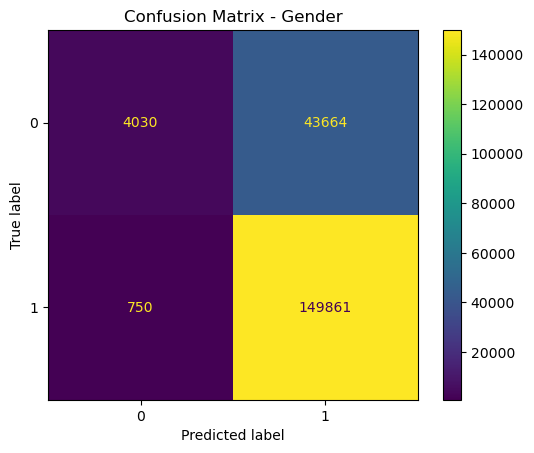

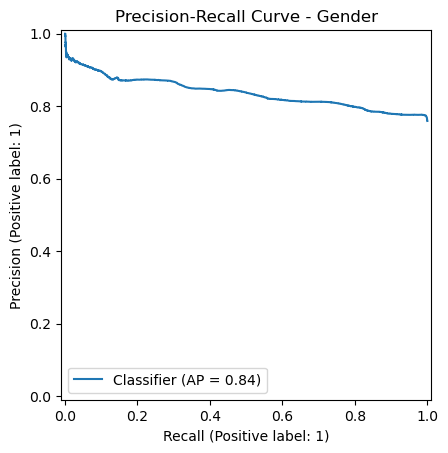

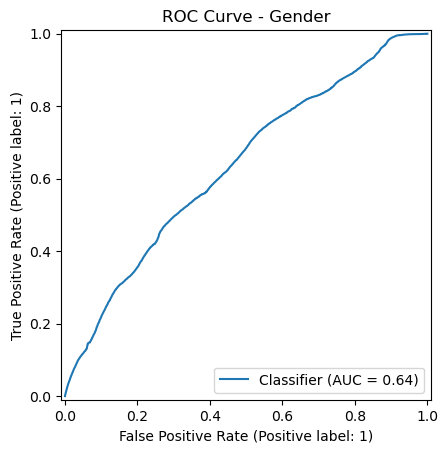


Training DeepFM model for Age prediction...
Number of Age Classes: 7

Training DeepFM model for Age Class 0...
Age Class 0 Weights: {0: 0.5833333333333334, 1: 3.5}
pos_weight for Age Class 0: tensor([0.1667], device='mps:0')
Resampled Age Class 0 distribution: {1: 1946526, 0: 1946526}
mps
Train on 3893052 samples, validate on 198305 samples, 15208 steps per epoch


KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import DeepFM
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, f1_score, 
    classification_report,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

# Проверка наличия MPS (для Mac с Apple Silicon)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS device")
else:
    device = torch.device('cpu')
    print("MPS device not found, using CPU")

# Загрузка данных
users_file = 'ml-1m/users.dat'
movies_file = 'ml-1m/movies.dat'
ratings_file = 'ml-1m/ratings.dat'

user_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
movie_cols = ['MovieID', 'Title', 'Genres']
rating_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']

# Загрузка датасетов
users = pd.read_csv(users_file, sep='::', names=user_cols, engine='python', encoding='latin-1')
movies = pd.read_csv(movies_file, sep='::', names=movie_cols, engine='python', encoding='latin-1')
ratings = pd.read_csv(ratings_file, sep='::', names=rating_cols, engine='python', encoding='latin-1')

# Объединение датасетов
data = pd.merge(ratings, users, on='UserID')
data = pd.merge(data, movies[['MovieID', 'Genres']], on='MovieID')

# Категориальные и числовые признаки
sparse_features = ['UserID', 'MovieID', 'Occupation', 'Zip-code', 'Genres']
dense_features = ['Rating', 'Timestamp']

# Целевая переменная для пола и возраста
data['Gender'] = data['Gender'].map({'M': 1, 'F': 0})

# Проверка на уникальность UserID
print("Total unique UserIDs:", data['UserID'].nunique())

# --- Новый шаг: Разделение данных на обучающую и тестовую выборки с уникальными UserID ---
# Получаем уникальные UserID
unique_users = data['UserID'].unique()

# Разделяем UserID на обучающую и тестовую выборки (например, 80% обучающих, 20% тестовых)
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

# Создаем обучающую и тестовую выборки на основе UserID
train_data = data[data['UserID'].isin(train_users)].reset_index(drop=True)
test_data = data[data['UserID'].isin(test_users)].reset_index(drop=True)

# Проверка на пересечение UserID
train_users_set = set(train_users)
test_users_set = set(test_users)
intersection = train_users_set.intersection(test_users_set)
if len(intersection) > 0:
    print(f"Warning: {len(intersection)} overlapping users between train and test")
else:
    print(f"No overlapping users between train and test")

# --- Функция для предобработки данных ---
def prepare_data(train, test, sparse_features, dense_features):
    train = train.copy()
    test = test.copy()
    
    # Кодирование категориальных признаков
    ordinal_encoders = {}
    for feat in sparse_features:
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        train[feat] = oe.fit_transform(train[[feat]]).astype(int)
        test[feat] = oe.transform(test[[feat]]).astype(int)
        ordinal_encoders[feat] = oe
    
    # Нормализация числовых признаков
    scaler = MinMaxScaler(feature_range=(0, 1))
    train[dense_features] = scaler.fit_transform(train[dense_features])
    test[dense_features] = scaler.transform(test[dense_features])
    
    return train, test, ordinal_encoders, scaler

# --- Предобработка данных ---
print("\nPreprocessing training and testing data...")
X_train, X_test, ordinal_encoders, scaler = prepare_data(train_data, test_data, sparse_features, dense_features)

# Разделение целевых переменных
y_gender_train = X_train['Gender']
y_gender_test = X_test['Gender']
y_age_train = X_train['Age']
y_age_test = X_test['Age']

# Удаление целевых переменных из признаков
X_train_gender = X_train[sparse_features + dense_features]
X_test_gender = X_test[sparse_features + dense_features]

X_train_age = X_train[sparse_features + dense_features]
X_test_age = X_test[sparse_features + dense_features]

# --- Обработка дисбаланса для Age ---
print("\nHandling class imbalance for Age using SMOTE...")
smote = SMOTE(random_state=42)
X_train_age_res, y_age_train_res = smote.fit_resample(X_train_age, y_age_train)

print(f"Original Age distribution: {y_age_train.value_counts().to_dict()}")
print(f"Resampled Age distribution: {pd.Series(y_age_train_res).value_counts().to_dict()}")

# Кодирование целевой переменной возраста как категориальных
label_encoder_age = LabelEncoder()
y_age_train_encoded = label_encoder_age.fit_transform(y_age_train_res)
y_age_test_encoded = label_encoder_age.transform(y_age_test)

# Определение feature columns для DeepCTR-Torch
fixlen_feature_columns = [
    SparseFeat(feat, vocabulary_size=X_train_gender[feat].nunique()+1, embedding_dim=8) for feat in sparse_features
] + [DenseFeat(feat, 1) for feat in dense_features]

feature_names = get_feature_names(fixlen_feature_columns)

# Преобразуем тип данных входных данных в float32
train_model_input_gender = {name: X_train_gender[name].values.astype(np.float32) for name in feature_names}
test_model_input_gender = {name: X_test_gender[name].values.astype(np.float32) for name in feature_names}

train_model_input_age = {name: X_train_age_res[name].values.astype(np.float32) for name in feature_names}
test_model_input_age = {name: X_test_age[name].values.astype(np.float32) for name in feature_names}

# --- Модель DeepFM для предсказания пола (Gender) ---
print("\nTraining DeepFM model for Gender prediction...")

# Вычисление весов классов
classes = np.unique(y_gender_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_gender_train)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print(f"Computed class weights for Gender: {class_weights_dict}")

# В PyTorch pos_weight определяет вес позитивного класса (здесь класс 1)
# Вычислим pos_weight как отношение числа отрицательных примеров к числу позитивных
neg, pos = class_weights_dict[0], class_weights_dict[1]
# Явно указываем dtype=torch.float32
pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight}")

# Определение пользовательской функции потерь с весами классов
class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
    def forward(self, y_pred, y_true, *args, **kwargs):
        # Добавим вывод для отладки
        # print(f"Custom loss received args: {args}, kwargs: {kwargs}")
        y_true = y_true.float()
        # Не передаем *args и **kwargs внутрь self.loss
        return self.loss(y_pred, y_true)

# Инициализация функции потерь
weighted_loss = WeightedBCEWithLogitsLoss(pos_weight=pos_weight)

# Определение метрик (например, AUC)
# DeepCTR-Torch поддерживает метрики как строки или функции
# Мы будем использовать AUC, а другие метрики вычислим позже
model_gender = DeepFM(
    linear_feature_columns=fixlen_feature_columns,
    dnn_feature_columns=fixlen_feature_columns,
    task='binary',
    l2_reg_embedding=1e-5,
    l2_reg_linear=1e-5,
    l2_reg_dnn=1e-5,
    device=device
)

# Компиляция модели с пользовательской функцией потерь
model_gender.compile("adam", weighted_loss, metrics=['AUC'])

# Обучение модели с ранней остановкой
history_gender = model_gender.fit(
    train_model_input_gender, y_gender_train.values.astype(np.float32),
    batch_size=256, epochs=10, verbose=2, 
    validation_data=(test_model_input_gender, y_gender_test.values.astype(np.float32)),
)

# Оценка модели на тестовой выборке
pred_ans_gender = model_gender.predict(test_model_input_gender, batch_size=256).flatten()

# Применение сигмоиды, так как DeepFM возвращает логиты
pred_probs_gender = torch.sigmoid(torch.tensor(pred_ans_gender, dtype=torch.float32)).numpy()

# Настройка порога классификации для улучшения recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_gender_test, pred_probs_gender)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold based on F1-Score: {optimal_threshold:.4f}")

# Применение оптимального порога
pred_label_gender = (pred_probs_gender >= optimal_threshold).astype(int)

# Метрики для пола
print("\n--- Gender Classification Metrics ---")
f1_gender = f1_score(y_gender_test, pred_label_gender)
roc_auc_gender = roc_auc_score(y_gender_test, pred_probs_gender)
report_gender = classification_report(y_gender_test, pred_label_gender)

print(f"AUC: {roc_auc_gender:.4f}")
print(f"F1-Score: {f1_gender:.4f}")
print("\nClassification Report:")
print(report_gender)

# Матрица ошибок для пола
ConfusionMatrixDisplay.from_predictions(y_gender_test, pred_label_gender)
plt.title(f'Confusion Matrix - Gender')
plt.show()

# Precision-Recall кривая для пола
PrecisionRecallDisplay.from_predictions(y_gender_test, pred_probs_gender)
plt.title(f'Precision-Recall Curve - Gender')
plt.show()

# ROC-кривая для пола
RocCurveDisplay.from_predictions(y_gender_test, pred_probs_gender)
plt.title(f'ROC Curve - Gender')
plt.show()

# --- Модель DeepFM для предсказания возраста (Age) ---
print("\nTraining DeepFM model for Age prediction...")

# Определение количества классов возраста
num_age_classes = len(label_encoder_age.classes_)
print(f"Number of Age Classes: {num_age_classes}")

# Инициализация списка моделей и вероятностей
models_age = []
prediction_probas_age = np.zeros((X_test_age.shape[0], num_age_classes))

for class_idx in range(num_age_classes):
    print(f"\nTraining DeepFM model for Age Class {class_idx}...")
    
    # Создание бинарных меток для текущего класса
    y_train_binary = (y_age_train_encoded == class_idx).astype(int)
    y_test_binary = (y_age_test_encoded == class_idx).astype(int)
    
    # Определение весов классов для текущего бинарного классификатора
    classes_array = np.array([0, 1])
    class_weights_age = compute_class_weight(class_weight='balanced', classes=classes_array, y=y_train_binary)
    class_weights_dict_age = {0: class_weights_age[0], 1: class_weights_age[1]}
    print(f"Age Class {class_idx} Weights: {class_weights_dict_age}")
    
    # Вычислим pos_weight для возраста
    neg_age, pos_age = class_weights_dict_age[0], class_weights_dict_age[1]
    pos_weight_age = torch.tensor([neg_age / pos_age], dtype=torch.float32).to(device)
    print(f"pos_weight for Age Class {class_idx}: {pos_weight_age}")
    
    # Определение пользовательской функции потерь с весами классов для возраста
    weighted_loss_age = WeightedBCEWithLogitsLoss(pos_weight=pos_weight_age)
    
    # Применение балансировки классов с помощью SMOTE для бинарной задачи
    smote_binary = SMOTE(random_state=42)
    X_train_age_binary_res, y_train_binary_res = smote_binary.fit_resample(X_train_age_res, y_train_binary)
    
    print(f"Resampled Age Class {class_idx} distribution: {pd.Series(y_train_binary_res).value_counts().to_dict()}")
    
    # Преобразуем входные данные
    train_model_input_age_binary = {name: X_train_age_binary_res[name].values.astype(np.float32) for name in feature_names}
    test_model_input_age_binary = {name: X_test_age[name].values.astype(np.float32) for name in feature_names}
    
    # Инициализация модели DeepFM для бинарной классификации возраста
    model_age = DeepFM(
        linear_feature_columns=fixlen_feature_columns,
        dnn_feature_columns=fixlen_feature_columns,
        task='binary',
        l2_reg_embedding=1e-5,
        l2_reg_linear=1e-5,
        l2_reg_dnn=1e-5,
        device=device
    )
    model_age.compile("adam", weighted_loss_age, metrics=['AUC'])
    
    # Обучение модели с ранней остановкой
    history_age = model_age.fit(
        train_model_input_age_binary, y_train_binary_res.astype(np.float32),
        batch_size=256, epochs=10, verbose=2, 
        validation_data=(test_model_input_age_binary, y_test_binary.astype(np.float32)),
    )
    
    # Предсказание вероятностей на тестовой выборке
    pred_proba_age = model_age.predict(test_model_input_age_binary, batch_size=256).flatten()
    prediction_probas_age[:, class_idx] = pred_proba_age
    
    # Сохранение модели
    models_age.append(model_age)

# Нормализация вероятностей, чтобы сумма по классам была равна 1
row_sums = prediction_probas_age.sum(axis=1, keepdims=True)
# Обработка возможных нулевых сумм
row_sums[row_sums == 0] = 1
prediction_probas_age = prediction_probas_age / row_sums

# Предсказание класса с наивысшей вероятностью
pred_label_age = prediction_probas_age.argmax(axis=1)

# Метрики для возраста
print("\n--- Age Classification Metrics ---")
f1_age = f1_score(y_age_test_encoded, pred_label_age, average='macro')
roc_auc_age = roc_auc_score(y_age_test_encoded, prediction_probas_age, multi_class='ovr')
report_age = classification_report(y_age_test_encoded, pred_label_age)

print(f"AUC (OvR): {roc_auc_age:.4f}")
print(f"F1-Score (Macro): {f1_age:.4f}")
print("\nClassification Report:")
print(report_age)

# Матрица ошибок для возраста
ConfusionMatrixDisplay.from_predictions(y_age_test_encoded, pred_label_age, display_labels=label_encoder_age.classes_)
plt.title(f'Confusion Matrix - Age')
plt.show()

# Precision-Recall кривые для каждого класса возраста
for class_idx in range(num_age_classes):
    plt.figure()
    PrecisionRecallDisplay.from_predictions(
        (y_age_test_encoded == class_idx).astype(int),
        prediction_probas_age[:, class_idx]
    )
    plt.title(f'Precision-Recall Curve - Age Class {class_idx}')
    plt.show()

# ROC-кривые для каждого класса возраста
for class_idx in range(num_age_classes):
    plt.figure()
    RocCurveDisplay.from_predictions(
        (y_age_test_encoded == class_idx).astype(int),
        prediction_probas_age[:, class_idx]
    )
    plt.title(f'ROC Curve - Age Class {class_idx}')
    plt.show()

print("\nTraining and evaluation completed.")


## Модель без кросс-валидации MyFm

No overlapping users between train and test
Обучение и оценка модели для предсказания пола (Gender):


w0 = 1.45 : 100%|█████████████████████████████| 200/200 [01:37<00:00,  2.06it/s]


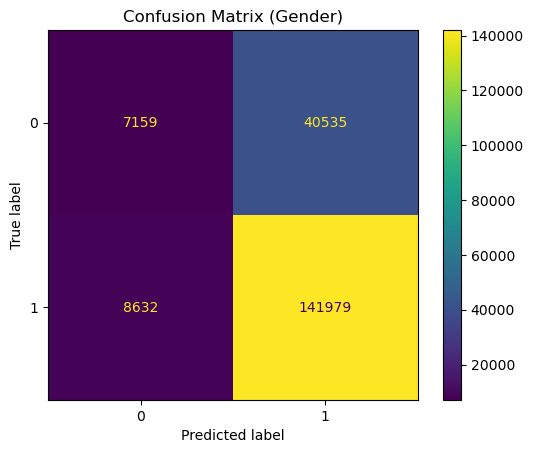

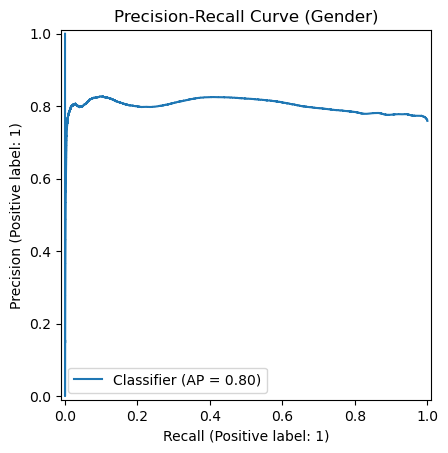

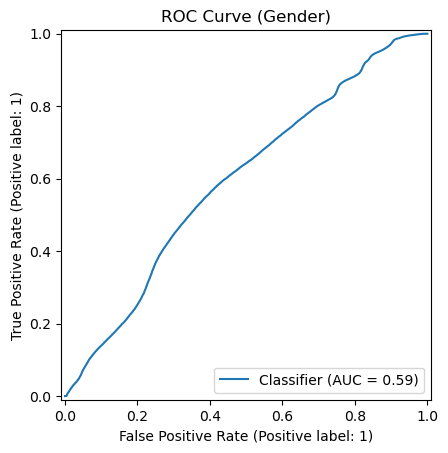

(Gender) - ROC AUC: 0.5948, Log Loss: 0.7238, Accuracy: 0.7521, F1 Score (Macro): 0.5390


Обучение и оценка модели для предсказания возраста (Age):

Training classifier for Age Class 0...


w0 = -3.16 : 100%|████████████████████████████| 200/200 [01:37<00:00,  2.05it/s]


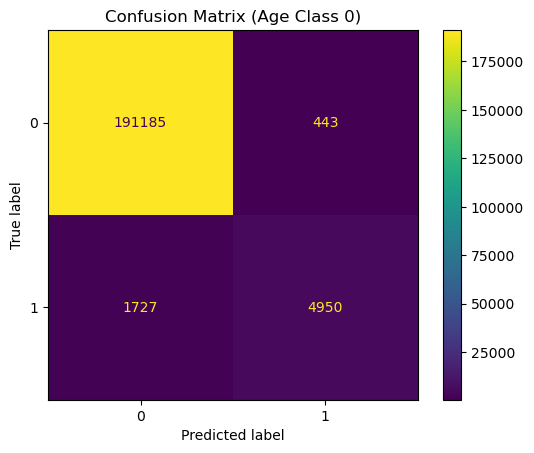

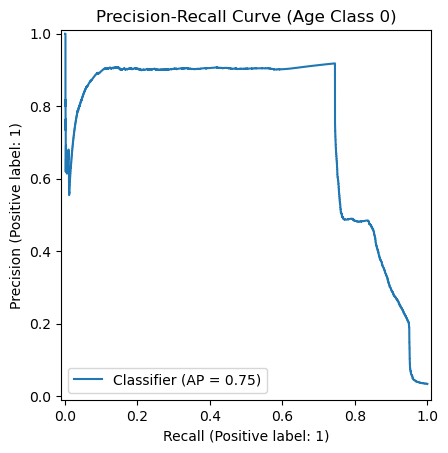

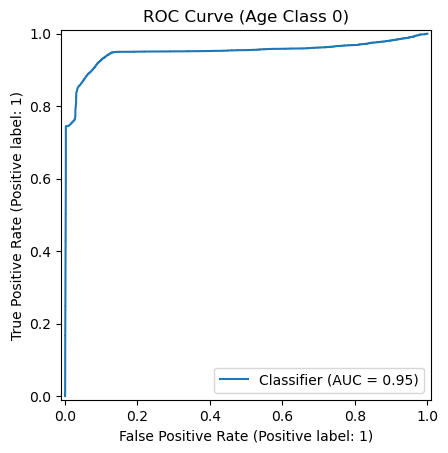

(Age Class 0) - ROC AUC: 0.9488, Log Loss: 0.0577, Accuracy: 0.9891, F1 Score (Macro): 0.9073


Training classifier for Age Class 1...


w0 = -2.22 : 100%|████████████████████████████| 200/200 [01:53<00:00,  1.77it/s]


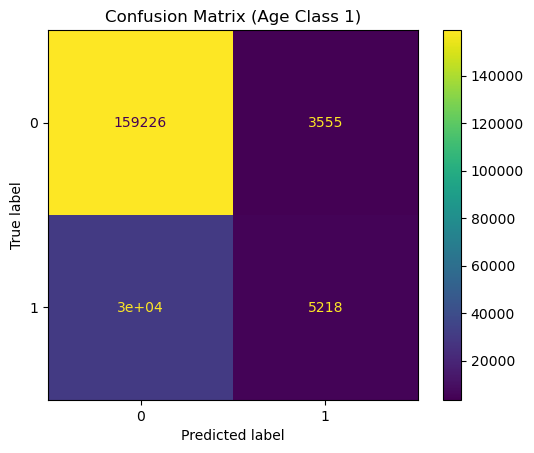

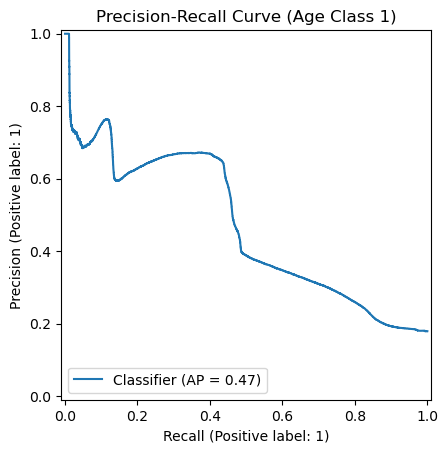

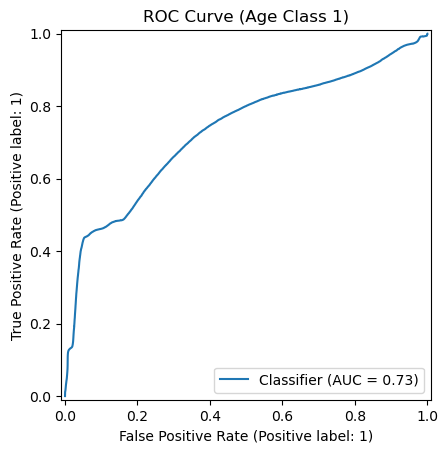

(Age Class 1) - ROC AUC: 0.7341, Log Loss: 0.5827, Accuracy: 0.8292, F1 Score (Macro): 0.5697


Training classifier for Age Class 2...


w0 = -0.80 : 100%|████████████████████████████| 200/200 [01:36<00:00,  2.07it/s]


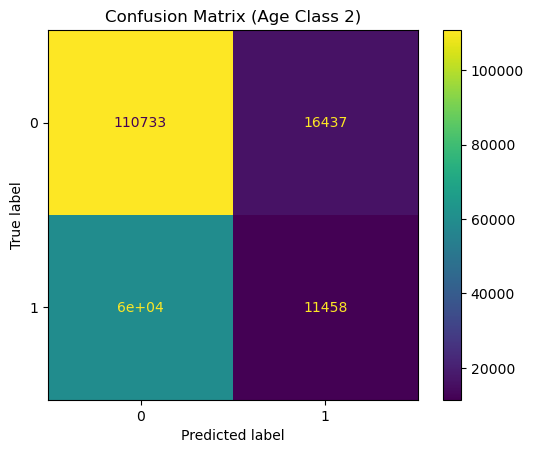

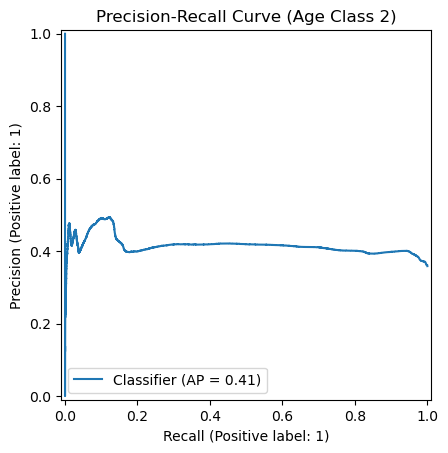

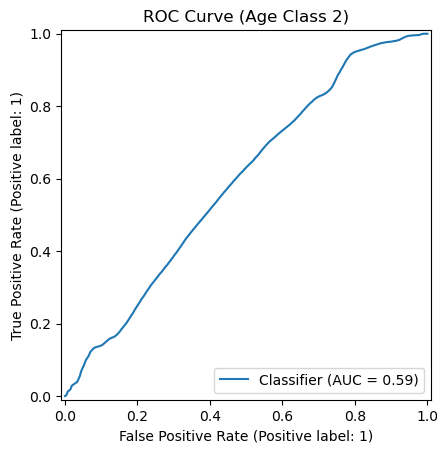

(Age Class 2) - ROC AUC: 0.5915, Log Loss: 0.7268, Accuracy: 0.6162, F1 Score (Macro): 0.4878


Training classifier for Age Class 3...


w0 = -2.16 : 100%|████████████████████████████| 200/200 [01:36<00:00,  2.07it/s]


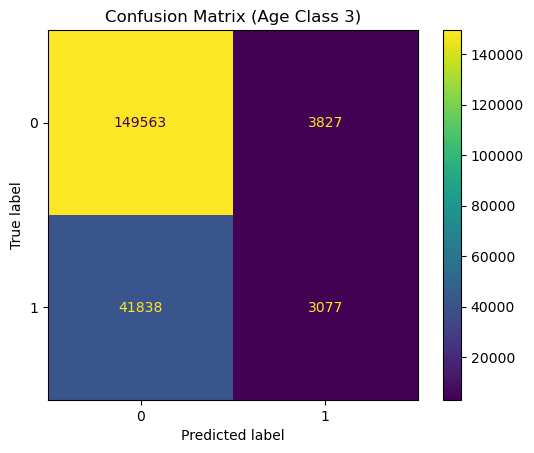

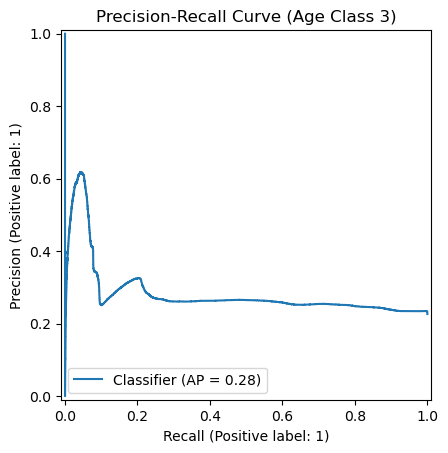

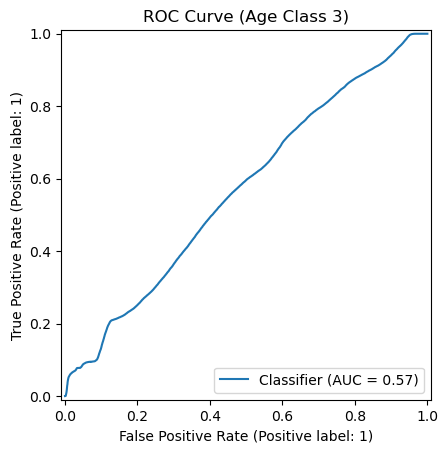

(Age Class 3) - ROC AUC: 0.5687, Log Loss: 0.8603, Accuracy: 0.7697, F1 Score (Macro): 0.4932


Training classifier for Age Class 4...


w0 = -2.82 : 100%|████████████████████████████| 200/200 [01:37<00:00,  2.06it/s]


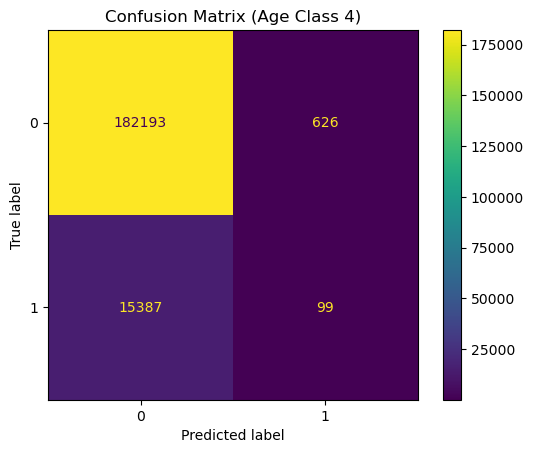

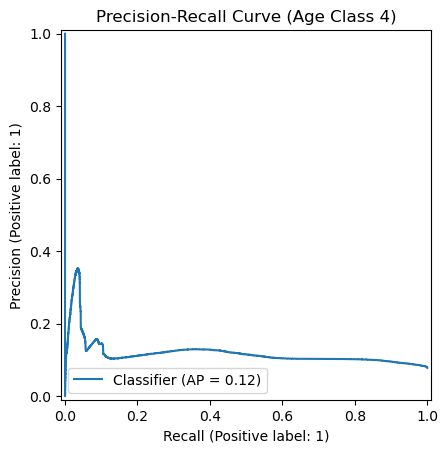

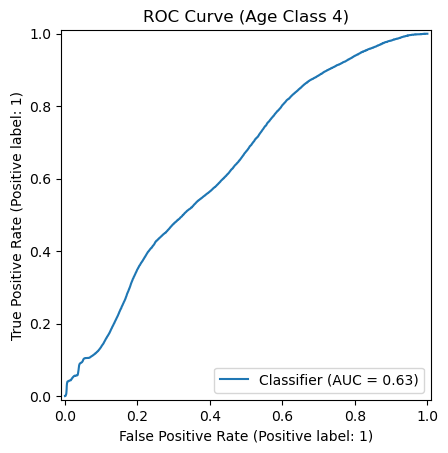

(Age Class 4) - ROC AUC: 0.6336, Log Loss: 0.4128, Accuracy: 0.9193, F1 Score (Macro): 0.4851


Training classifier for Age Class 5...


w0 = -2.89 : 100%|████████████████████████████| 200/200 [01:36<00:00,  2.07it/s]


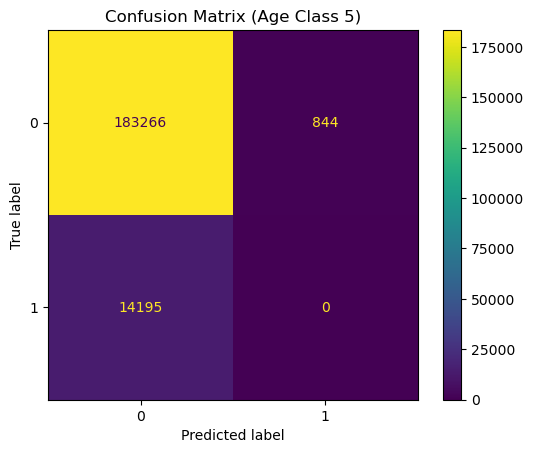

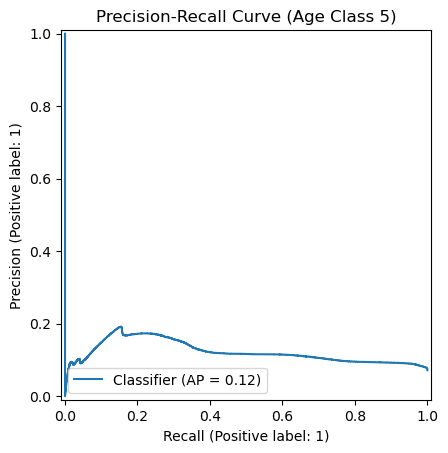

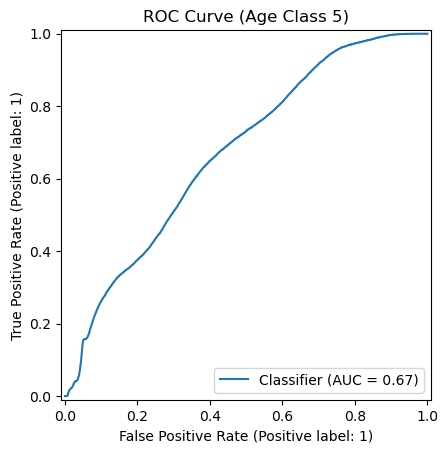

(Age Class 5) - ROC AUC: 0.6735, Log Loss: 0.3720, Accuracy: 0.9242, F1 Score (Macro): 0.4803


Training classifier for Age Class 6...


w0 = -3.09 : 100%|████████████████████████████| 200/200 [01:36<00:00,  2.08it/s]


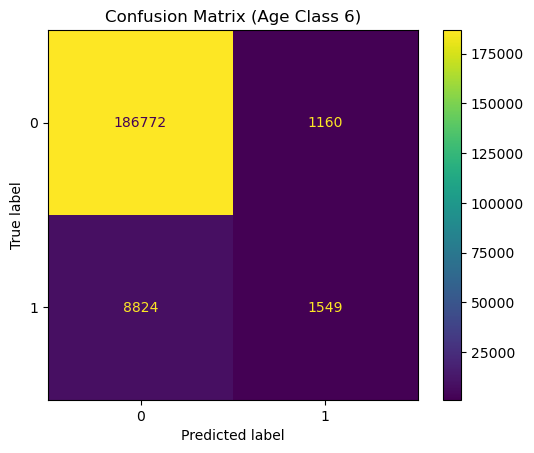

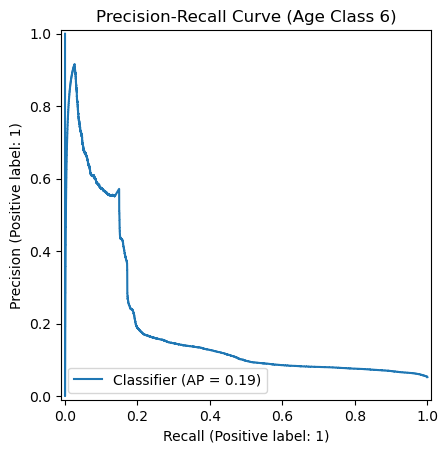

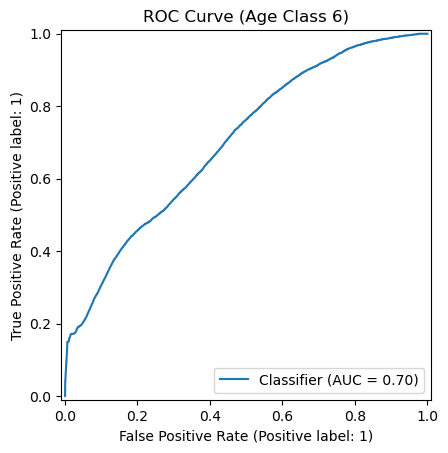

(Age Class 6) - ROC AUC: 0.7015, Log Loss: 0.2834, Accuracy: 0.9497, F1 Score (Macro): 0.6054



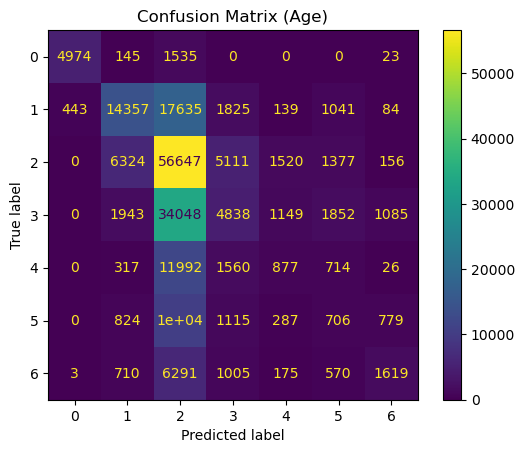

(Age) - ROC AUC (OvR): 0.6948, Log Loss: 2.1250, Accuracy: 0.4237, F1 Score (Macro): 0.3411


Обучение и оценка завершены.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import myfm
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)
import joblib

# Шаг 1: Загрузка данных
users_file = 'ml-1m/users.dat'
movies_file = 'ml-1m/movies.dat'
ratings_file = 'ml-1m/ratings.dat'

user_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
movie_cols = ['MovieID', 'Title', 'Genres']
rating_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']

users = pd.read_csv(users_file, sep='::', names=user_cols, engine='python', encoding='latin-1')
movies = pd.read_csv(movies_file, sep='::', names=movie_cols, engine='python', encoding='latin-1')
ratings = pd.read_csv(ratings_file, sep='::', names=rating_cols, engine='python', encoding='latin-1')

# Шаг 2: Объединение данных
data = pd.merge(pd.merge(ratings, users, on='UserID'), movies, on='MovieID')

def prepare_data_for_target_prediction(train_data, test_data, target):
    # Создаём копии данных для избежания предупреждений SettingWithCopyWarning
    train_data = train_data.copy()
    test_data = test_data.copy()
    
    # Предобработка и кодирование данных
    if target == 'Gender':
        train_data['Gender'] = train_data['Gender'].map({'M': 1, 'F': 0})
        test_data['Gender'] = test_data['Gender'].map({'M': 1, 'F': 0})
    else:
        age_mapping = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
        train_data['Age'] = train_data['Age'].map(age_mapping)
        test_data['Age'] = test_data['Age'].map(age_mapping)
    
    # Обработка жанров
    genres_train = train_data['Genres'].str.get_dummies('|')
    genres_test = test_data['Genres'].str.get_dummies('|')
    
    # Добавляем недостающие столбцы жанров в тестовую выборку
    genres_test = genres_test.reindex(columns=genres_train.columns, fill_value=0)
    
    # Объединяем данные с жанрами
    train_data = pd.concat([train_data, genres_train], axis=1)
    test_data = pd.concat([test_data, genres_test], axis=1)
    
    # Удаляем исходный столбец Genres
    train_data.drop('Genres', axis=1, inplace=True)
    test_data.drop('Genres', axis=1, inplace=True)
    
    # Определение признаков
    categorical_features = ['UserID', 'MovieID', 'Occupation', 'Zip-code']
    numerical_features = ['Rating', 'Timestamp']
    genre_features = genres_train.columns.tolist()
    
    # One-Hot Encoding для категориальных признаков
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_categorical = ohe.fit_transform(train_data[categorical_features])
    X_val_categorical = ohe.transform(test_data[categorical_features])
    
    # Масштабирование числовых признаков
    scaler = StandardScaler()
    X_train_numerical = scaler.fit_transform(train_data[numerical_features])
    X_val_numerical = scaler.transform(test_data[numerical_features])
    
    # Обработка жанров как числовых признаков
    X_train_genres = train_data[genre_features].values
    X_val_genres = test_data[genre_features].values
    
    # Объединение всех признаков
    X_train = sparse.hstack([X_train_categorical, X_train_numerical, X_train_genres])
    X_val = sparse.hstack([X_val_categorical, X_val_numerical, X_val_genres])
    
    # Целевая переменная
    y_train = train_data[target]
    y_val = test_data[target]
    
    return X_train, X_val, y_train, y_val, ohe, scaler

# --- Новый шаг: Разделение данных на обучающую и тестовую выборки с уникальными UserID ---
# Получаем уникальные UserID
unique_users = data['UserID'].unique()

# Разделяем UserID на обучающую и тестовую выборки (например, 80% обучающих, 20% тестовых)
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

# Создаем обучающую и тестовую выборки на основе UserID
train_data = data[data['UserID'].isin(train_users)].reset_index(drop=True)
test_data = data[data['UserID'].isin(test_users)].reset_index(drop=True)

# Проверка на пересечение UserID
train_users_set = set(train_users)
test_users_set = set(test_users)
intersection = train_users_set.intersection(test_users_set)
if len(intersection) > 0:
    print(f"Warning: {len(intersection)} overlapping users between train and test")
else:
    print(f"No overlapping users between train and test")

def evaluate_binary_classification(y_true, y_pred, y_proba, title_prefix=""):
    # Матрица ошибок
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f'Confusion Matrix {title_prefix}')
    plt.show()
    
    # Precision-Recall кривая
    PrecisionRecallDisplay.from_predictions(y_true, y_proba)
    plt.title(f'Precision-Recall Curve {title_prefix}')
    plt.show()
    
    # ROC-кривая
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f'ROC Curve {title_prefix}')
    plt.show()
    
    # Вычисление метрик
    roc = metrics.roc_auc_score(y_true, y_proba)
    ll = metrics.log_loss(y_true, y_proba)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred, average='macro')
    print(f"{title_prefix} - ROC AUC: {roc:.4f}, Log Loss: {ll:.4f}, Accuracy: {accuracy:.4f}, F1 Score (Macro): {f1:.4f}\n")

def evaluate_multiclass_classification(y_true, y_pred, y_proba, title_prefix=""):
    # Матрица ошибок
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f'Confusion Matrix {title_prefix}')
    plt.show()
    
    # Вычисление метрик
    roc = metrics.roc_auc_score(y_true, y_proba, multi_class='ovr')
    ll = metrics.log_loss(y_true, y_proba)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred, average='macro')
    print(f"{title_prefix} - ROC AUC (OvR): {roc:.4f}, Log Loss: {ll:.4f}, Accuracy: {accuracy:.4f}, F1 Score (Macro): {f1:.4f}\n")

# Готовим данные для предсказания пола
X_train_gender, X_test_gender, y_train_gender, y_test_gender, ohe_gender, scaler_gender = prepare_data_for_target_prediction(train_data, test_data, target='Gender')

# Готовим данные для предсказания возраста
X_train_age, X_test_age, y_train_age, y_test_age, ohe_age, scaler_age = prepare_data_for_target_prediction(train_data, test_data, target='Age')

# --- Функция для обучения и оценки модели ---
def train_and_evaluate_model(X_train, y_train, X_test, y_test, target='Gender', variational=False, rank=8):
    if target == 'Gender':
        # Бинарная классификация
        fm = myfm.VariationalFMClassifier(rank=rank, random_seed=334) if variational else myfm.MyFMClassifier(rank=rank, random_seed=334)
        fm.fit(X_train, y_train, n_iter=200)
        prediction_proba = fm.predict_proba(X_test)
        prediction = (prediction_proba >= 0.5).astype(int)
        
        # Оценка и визуализация
        evaluate_binary_classification(y_test, prediction, prediction_proba, title_prefix=f'(Gender)')
        
    else:
        # Многоклассовая классификация через One-vs-Rest
        unique_classes = y_train.nunique()
        models = []
        prediction_probas = []
        for class_idx in range(unique_classes):
            print(f"\nTraining classifier for Age Class {class_idx}...")
            # Создаём бинарную метку для текущего класса
            y_train_binary = (y_train == class_idx).astype(int)
            y_test_binary = (y_test == class_idx).astype(int)
            
            # Инициализируем классификатор
            fm = myfm.VariationalFMClassifier(rank=rank, random_seed=334) if variational else myfm.MyFMClassifier(rank=rank, random_seed=334)
            fm.fit(X_train, y_train_binary, n_iter=200)
            
            # Предсказание вероятностей на тестовых данных
            prediction_proba = fm.predict_proba(X_test)
            
            # Проверка размерности и изменение формы, если необходимо
            if prediction_proba.ndim == 1:
                prediction_proba = prediction_proba.reshape(-1, 1)
            
            prediction_probas.append(prediction_proba)
            prediction_class = (prediction_proba >= 0.5).astype(int)
            
            # Оценка и визуализация для текущего класса
            evaluate_binary_classification(y_test_binary, prediction_class, prediction_proba, title_prefix=f'(Age Class {class_idx})')
            
            models.append(fm)
        
        # После обучения всех бинарных классификаторов для возраста, объединяем предсказания
        prediction_probas = np.hstack(prediction_probas)  # shape (n_samples, n_classes)
        
        # Нормализация вероятностей, чтобы сумма по классам была равна 1
        row_sums = prediction_probas.sum(axis=1, keepdims=True)
        # Обработка возможных нулевых сумм
        row_sums[row_sums == 0] = 1
        prediction_probas = prediction_probas / row_sums
        
        # Предсказание класса с наивысшей вероятностью
        prediction = prediction_probas.argmax(axis=1)
        
        # Оценка и визуализация для многоклассовой задачи
        evaluate_multiclass_classification(y_test, prediction, prediction_probas, title_prefix=f'(Age)')
        
    return fm  # Возвращаем последнюю модель (можно изменить по необходимости)

# --- Обучение и оценка модели для Gender ---
print("Обучение и оценка модели для предсказания пола (Gender):")
model_gender = train_and_evaluate_model(X_train_gender, y_train_gender, X_test_gender, y_test_gender, target='Gender', variational=True, rank=8)

# --- Обучение и оценка модели для Age ---
print("\nОбучение и оценка модели для предсказания возраста (Age):")
model_age = train_and_evaluate_model(X_train_age, y_train_age, X_test_age, y_test_age, target='Age', variational=True, rank=8)

print("\nОбучение и оценка завершены.")
